# Aproximating the optical band gap of a thin film material using Python and the Tauc method.

## Libraries, file import and data preprocessing


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import warnings

In [2]:
#Import the data of the optical measurements

# data of Transmittance (T)
data_T = pd.read_csv('T_TNT_1h.txt', skiprows=17, sep='\t', header=None, names=['wavelength', 'T']) 

# data of Reflectance (R)
data_R = pd.read_csv('R_TNT_1h.txt', skiprows=17, sep='\t', header=None, names=['wavelength', 'R'])


In [3]:
# creating a single Pandas Data Frame from which further calculations will be conducted
sample = pd.merge(left=data_T, right=data_R)

# removing the "">>>>>End Processed Spectral Data<<<<<" text from the end of the dataset
sample = sample[:-1]

# converting the data in the wavelength column to float 64
sample['wavelength'] = sample['wavelength'].astype(float)


## Define the thickness of the film you have previously experimentally determined


In [4]:
#Before starting the different calculations input here the thickness (d) of the thin film im nm
d = 1140
d = d/1e09 #converts into m


## Calculations and plotting for the Eg estimations (Tauc method)


In [5]:
#calculating the Absorbance (A) of the film. 
sample['A'] = 100.00 - sample['T'] - sample['R']

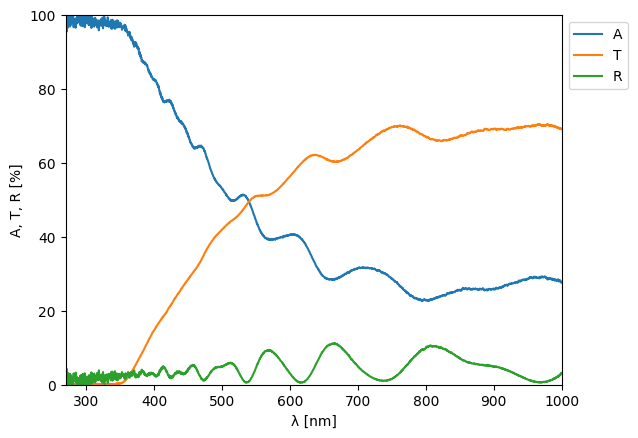

In [6]:
#Plotting the values of T, R, A dependant on the wavelength
warnings.filterwarnings("ignore", category=FutureWarning) # removing a Future Warning that indicates something will be deprecated in a future version
graphA = sns.lineplot(data = sample, x = 'wavelength', y = 'A', label = 'A')
graphT = sns.lineplot(data = sample, x = 'wavelength', y = 'T', label = 'T')
graphR = sns.lineplot(data = sample, x = 'wavelength', y = 'R', label = 'R')

graphA.set(xlim=(270, 1000), ylim=(0,100))
graphA.set(xlabel = 'λ [nm]', ylabel="A, T, R [%]")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [7]:
# T/A is needed for this variation of the aproximation of the absorption coefficient (α)
sample['T/A'] = sample['T']/sample['A']


# However, due to high sensor noise at high energies (small wavelengths) some of the results in column T/A are negative which is a problem when we want to calculate the ln(T/A).
## Therefore we implement a filter:
filter = sample['T/A'] > 0
sample = sample[filter]



In [8]:
# Calculating the absorption coefficient (α) of the material.  
sample['α'] = (-1/d)*(np.log(sample['T/A']))

#The abosrption coefficient describes how much light is absorbed by a given thickness of a material
#There are many different formulas and variations how to calculate this value. Feel free to change this formula to any other.

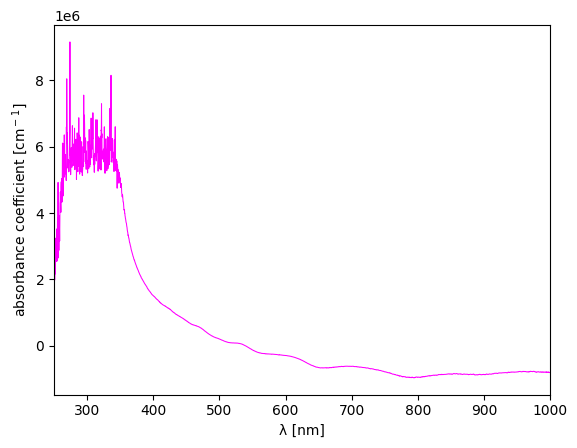

In [9]:
#Plotting the change in α of the sample in regards to the wavelength
graphAbsCoef = sns.lineplot(sample, x = 'wavelength', y = 'α', size=2, color="magenta", legend = None)
graphAbsCoef.set(xlim=(250, 1000))
graphAbsCoef.set(xlabel = 'λ [nm]', ylabel = "absorbance coefficient [cm$^-$$^1$]")
plt.show()
#TiO2 has a characteristic high absorption in the UV part of the EM spectrum.

In [10]:
#Convertion the wavelength into photon energies (E) in electron volts [eV] E=hc\λ
sample['E'] = 1240/(sample['wavelength'])

In [11]:
#depending on the type of semiconductor we calculate differently:
##indirect band-gap: (α*hν)^1/2  ----- We use this one in the case of anatase TiO2
##direct band-gap: (α*hν)^2
αhν = (sample['α']*sample['E'])

In [12]:
sample['(αhν)$^2$'] = np.power(αhν, 2) #ind. Eg
sample['(αhν)$^1$$^/$$^2$'] = np.sqrt(αhν) # dir. Eg
y_ind = sample['(αhν)$^1$$^/$$^2$']
y_dir = sample['(αhν)$^2$']
sample.head()

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,wavelength,T,R,A,T/A,α,E,(αhν)$^2$,(αhν)$^1$$^/$$^2$
19,200.40,12.228,0.0,87.772,0.139315,1.728960e+06,6.187625,1.144505e+14,3270.803307
20,200.67,5.140,0.0,94.860,0.054185,2.557324e+06,6.179299,2.497180e+14,3975.231917
21,200.94,8.741,0.0,91.259,0.095782,2.057611e+06,6.170996,1.612268e+14,3563.356913
22,201.21,9.809,0.0,90.191,0.108758,1.946166e+06,6.162716,1.438481e+14,3463.187535
23,201.48,9.249,0.0,90.751,0.101916,2.003161e+06,6.154457,1.519887e+14,3511.178015


[Text(0.5, 1.0, 'Direct band-gap equation')]

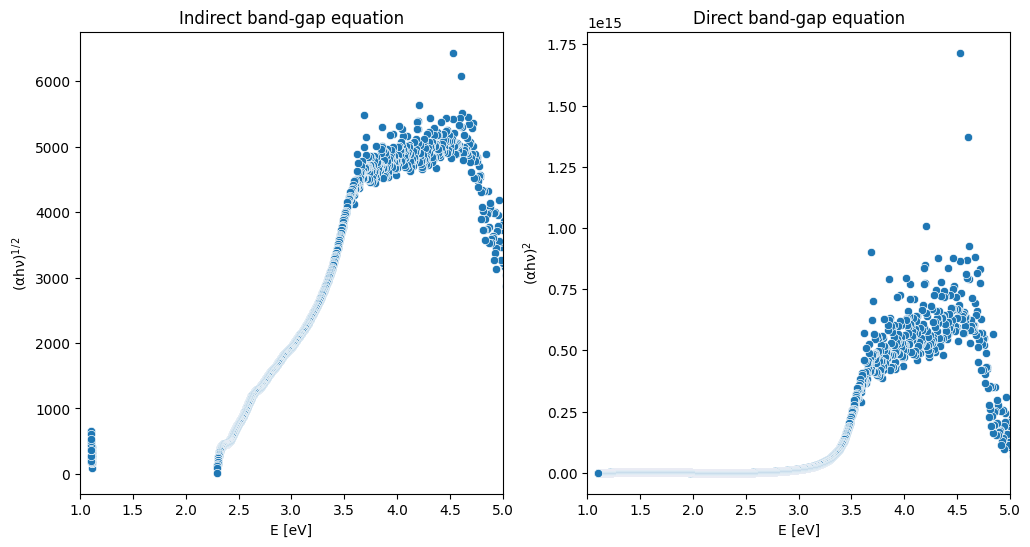

In [13]:
#Plotting the Tauc plots required for the Eg aproximation
f, axis = plt.subplots(1,2, figsize = (12,6))
ind_ = sns.scatterplot(data = sample, x = 'E', y = '(αhν)$^1$$^/$$^2$', ax = axis[0])
dir_ = sns.scatterplot(data = sample, x = 'E', y = '(αhν)$^2$', ax = axis[1])
ind_.set(xlim =(1,5))
dir_.set(xlim =(1,5))
ind_.set(xlabel = 'E [eV]', ylabel = "(αhν)$^1$$^/$$^2$")
dir_.set(xlabel = 'E [eV]', ylabel = "(αhν)$^2$")
ind_.set(title = 'Indirect band-gap equation')
dir_.set(title = 'Direct band-gap equation')


From the linear part of the calculated Tauc plots we extrapolate this linear region and where that line intercepts the x-axis we aproximate the value of the Eg. 
--

In [14]:
#Define the linear part of the data from which to perform the Linear Regression model

#Indirect Eg aproximation
filter_ind_subset_E = (sample['E'] > 3.41) & (sample['E'] < 3.51)

#Direct Eg aproximation
filter_dir_subset_E = (sample['E'] > 3.45) & (sample['E'] < 3.56)


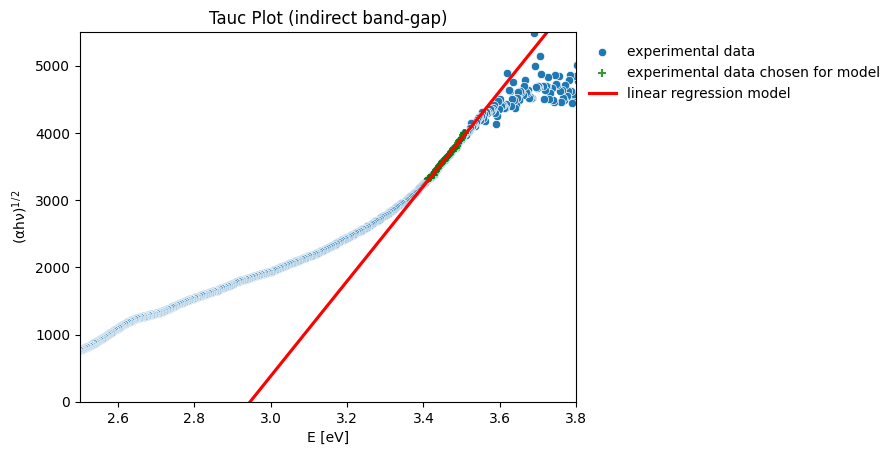

y = ax+b
y = 7065.113x + (-20813.626)
Eg = 2.95 eV


In [15]:
#Indirect Eg
ind_ = sns.scatterplot(data = sample, x = 'E', y = '(αhν)$^1$$^/$$^2$')
reg_ind = sns.regplot(data = sample[filter_ind_subset_E], x = 'E', y = '(αhν)$^1$$^/$$^2$', 
                      ci=None, truncate = False, fit_reg = True,scatter = True, 
                      color = 'red', marker = '+', 
                      scatter_kws={'color':'green'})
ind_.set(xlim =(2.5,3.8), ylim=(0,5500))
ind_.set(title = 'Tauc Plot (indirect band-gap)')
ind_.set(xlabel = 'E [eV]', ylabel = "(αhν)$^1$$^/$$^2$")
slope, intercept, r, p, sterr = scipy.stats.linregress(x=reg_ind.get_lines()[0].get_xdata(),
                                                       y=reg_ind.get_lines()[0].get_ydata())
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), 
           labels = ['experimental data', 'experimental data chosen for model', 'linear regression model'],
          frameon = False)
plt.show()
print('y = ax+b')
print('y = ' + str(round(slope,3)) + 'x'+ ' + '+ '('+ str(round(intercept,3))+')')
x_intercept = (-intercept/slope)
print('Eg =', round(x_intercept,2), 'eV')


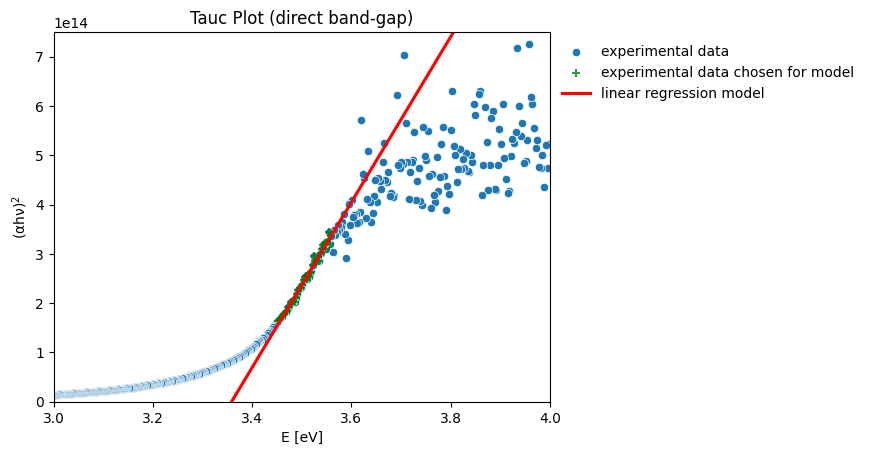

y = ax+b
y = 1676771005404861.8x + (-5631550827202710.0)
Eg = 3.36 eV


In [16]:
##Direct Eg
dir_ = sns.scatterplot(data = sample, x = 'E', y = '(αhν)$^2$')
reg_dir = sns.regplot(data = sample[filter_dir_subset_E], x = 'E', y = '(αhν)$^2$', 
                      ci=None, truncate = False, fit_reg = True, scatter = True, 
                      color = 'red', marker = '+', 
                      scatter_kws={'color':'green'})
dir_.set(title = 'Tauc Plot (direct band-gap)')
dir_.set(xlabel = 'E [eV]', ylabel = "(αhν)$^2$")
dir_.set(xlim=(3,4), ylim=(0,0.75*1e15))
slope, intercept, r, p, sterr = scipy.stats.linregress(x=reg_dir.get_lines()[0].get_xdata(),
                                                       y=reg_dir.get_lines()[0].get_ydata())
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), 
           labels = ['experimental data', 'experimental data chosen for model', 'linear regression model'],
          frameon = False)
plt.show()
print('y = ax+b')
print('y = ' + str(round(slope,3)) + 'x'+ ' + '+ '('+ str(round(intercept,3))+')')
x_intercept = (-intercept/slope)
print('Eg =', round(x_intercept,2), 'eV')

**Because of our prior knowledge we know that our sample (titanium dioxide) has a indirect band gap. So we accept the calculation of 2.95 eV.**
